Setup

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / "src"))  # Bootstrap path to allow `services` import
from services.env import setup_project
setup_project()


✅ Project path added to sys.path: d:\portfolio_repo\arb_airdrop\src


In [3]:
#API connection and dependency install
import os
from flipside import Flipside
from dotenv import find_dotenv, load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from services.config import DATA_DIR, API_KEY

Initialize flipside client

In [5]:

flipside = Flipside(API_KEY, "https://api-v2.flipsidecrypto.xyz") #had to do some digging thru the documentation to get the correct url

Run Base Query

In [6]:

sql = """
select 
'arbitrum' AS blockchain, 
'arbitrum' as airdrop, 
'claim' AS action_type, 
tx_hash, 
block_timestamp, 
contract_address, 
to_address AS user_address, 
amount, 
amount_usd 
FROM arbitrum.core.ez_token_transfers 
where from_address = lower('0x67a24CE4321aB3aF51c2D0a4801c3E111D88C9d9') and 
contract_address = lower('0x912CE59144191C1204E64559FE8253a0e49E6548')
and amount > 0
"""
arb_drop = flipside.query(sql)

In [7]:
#Convert to pandas df

#Define cols and rows
columns = arb_drop.columns
rows = arb_drop.rows

#create dataframe
arb_drop_df = pd.DataFrame(rows, columns=columns)

In [8]:
#Check table size in mem to determine pandas vs pyspark
mem_usage = arb_drop_df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"Total memory usage: {mem_usage:.2f} MB")

Total memory usage: 53.60 MB


In [ ]:


#convert block_timestamp to timestamp #doing to make partitioning on date and time better
arb_drop_df["block_timestamp"] = pd.to_datetime(arb_drop_df['block_timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')
arb_drop_df['block_date'] = pd.to_datetime(arb_drop_df['block_timestamp'].dt.date)

print(arb_drop_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   blockchain        100000 non-null  object        
 1   airdrop           100000 non-null  object        
 2   action_type       100000 non-null  object        
 3   tx_hash           100000 non-null  object        
 4   block_timestamp   100000 non-null  datetime64[ns]
 5   contract_address  100000 non-null  object        
 6   user_address      100000 non-null  object        
 7   amount            100000 non-null  int64         
 8   amount_usd        81162 non-null   float64       
 9   __row_index       100000 non-null  int64         
 10  block_date        100000 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 8.4+ MB
None


In [10]:
#see header data
display(arb_drop_df.head())

,blockchain,airdrop,action_type,tx_hash,block_timestamp,contract_address,user_address,amount,amount_usd,__row_index,block_date
0,arbitrum,arbitrum,claim,0x9f41ea6bfcbe6d972ff3645bd2530a2ace6d61b1eee2...,2023-03-28 23:57:35,0x912ce59144191c1204e64559fe8253a0e49e6548,0x90fd36be4761a951ca9e9171c17fcfaa741b7da0,1125,1340.765842,0,2023-03-28
1,arbitrum,arbitrum,claim,0x64eb0a513100b0a5148fb702424b1fa5534e1ae3c954...,2023-03-28 03:40:54,0x912ce59144191c1204e64559fe8253a0e49e6548,0xd37cbdb6e64ad8872800188d2934675723c6a046,1750,1999.893927,1,2023-03-28
2,arbitrum,arbitrum,claim,0x7ebcc011b46a7e7566999a84ffd9144dcbb92509b571...,2023-03-28 12:01:17,0x912ce59144191c1204e64559fe8253a0e49e6548,0x3250dabb584f7fea1bafaff6000ffbbd2f419a15,1500,1693.045551,2,2023-03-28
3,arbitrum,arbitrum,claim,0x4e0b97bc90e577a461c3803c4c36c3b5c60f016cd9ab...,2023-03-28 03:28:22,0x912ce59144191c1204e64559fe8253a0e49e6548,0xc551bd0275f187ce742f23dafcb9ef31ee82b836,875,999.946963,3,2023-03-28
4,arbitrum,arbitrum,claim,0x70d4e5f53bac3e1ce8bd2e4f8867dd33a91847cdcb2b...,2023-03-28 03:42:52,0x912ce59144191c1204e64559fe8253a0e49e6548,0x8793bd0ca22eaac2088afd56858a929ed4d16359,1125,1285.646096,4,2023-03-28


In [ ]:
#save data in data/processed
#save csv
arb_drop_df.to_csv(DATA_DIR/"arb_drop_path", index= False)

Basic EDA

In [12]:
#Size of df
print("Dimesion:", arb_drop_df.shape)

#min/max date time
print("Min Date:", arb_drop_df['block_date'].min())
print("Max Date:", arb_drop_df['block_date'].max())

#Unique Count of wallets
print("Total Claimed Wallets:", arb_drop_df['user_address'].nunique())

Dimesion: (100000, 11)
Min Date: 2023-03-23 00:00:00
Max Date: 2023-09-23 00:00:00
Total Claimed Wallets: 100000


Visualizations

Histograms to understand overall shape of amount and amount usd dropped to users

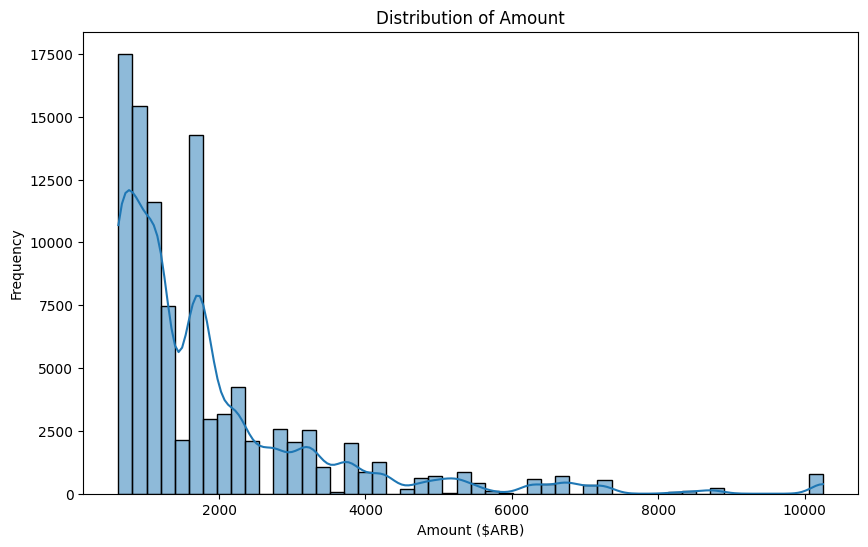

In [13]:
# Amount distribution
plt.figure(figsize=(10, 6))
sns.histplot(arb_drop_df['amount'], bins=50, kde=True)
plt.title('Distribution of Amount')
plt.xlabel('Amount ($ARB)')
plt.ylabel('Frequency')
plt.show()

Observations: 
- Heavy left skew to the distribution, with most transactions being under 2000 $ARB
- Long tail of fewer high-value transactions. May be worth considering using log transformation for scaling

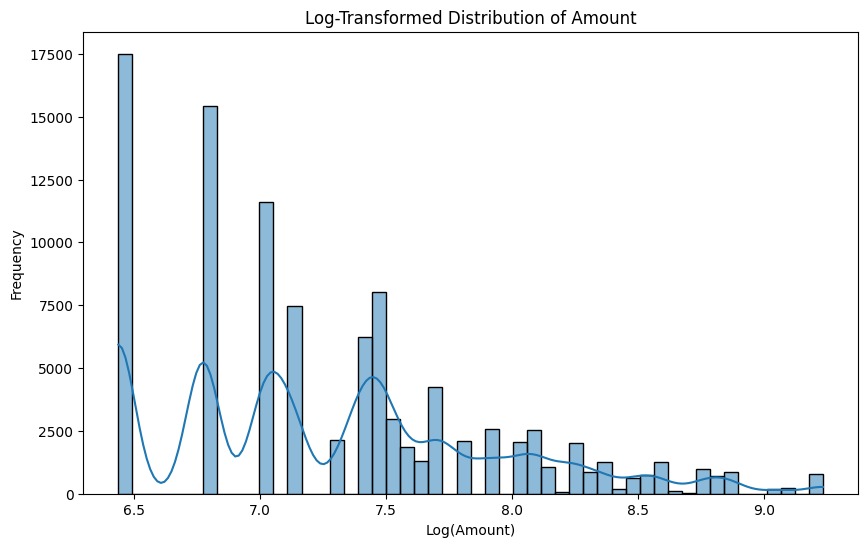

In [14]:
# Add small constant to avoid log(0)
arb_drop_df['log_amount'] = np.log1p(arb_drop_df['amount'])

plt.figure(figsize=(10, 6))
sns.histplot(arb_drop_df['log_amount'], bins=50, kde=True)
plt.title('Log-Transformed Distribution of Amount')
plt.xlabel('Log(Amount)')
plt.ylabel('Frequency')
plt.show()

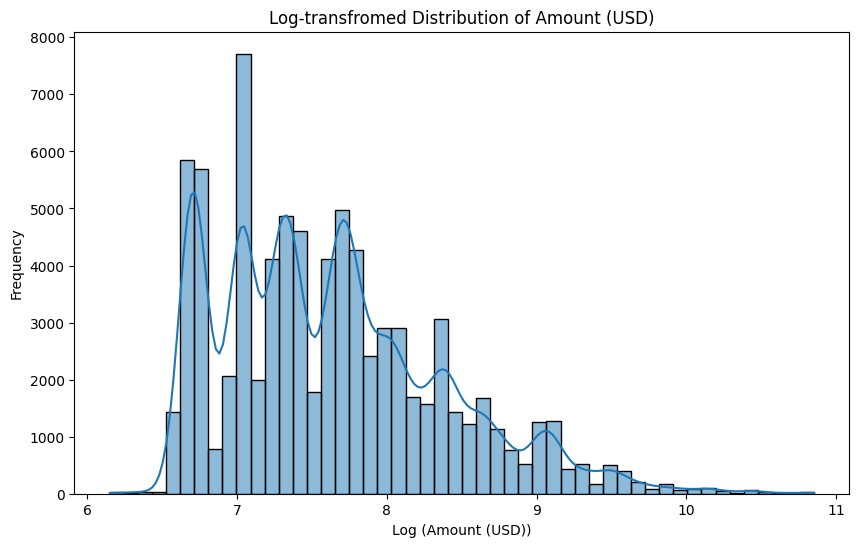

In [15]:

arb_drop_df['log_amount_usd'] = np.log1p(arb_drop_df['amount_usd'])

# Amount USD distribution
plt.figure(figsize=(10, 6))
sns.histplot(arb_drop_df['log_amount_usd'], bins=50, kde=True)
plt.title('Log-transfromed Distribution of Amount (USD)')
plt.xlabel('Log (Amount (USD))')
plt.ylabel('Frequency')
plt.show()

Observation: Same trend is apparent in the amount usd chart.

Box plots to visualize outliers

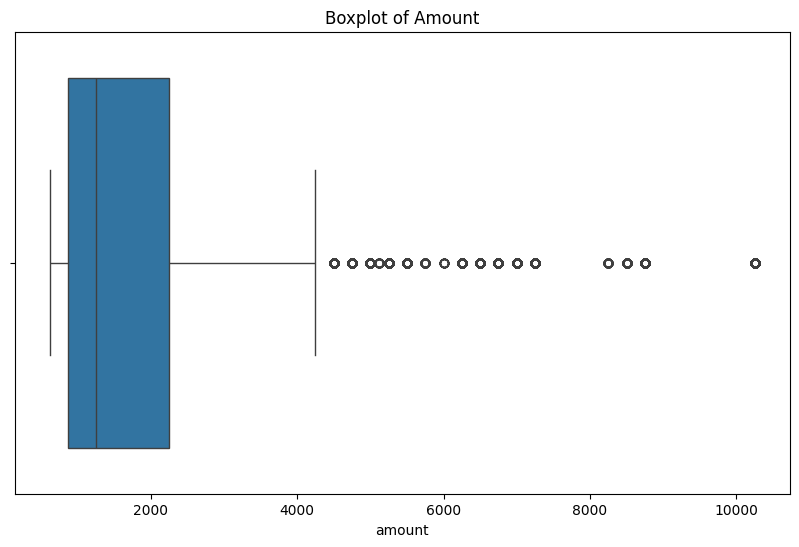

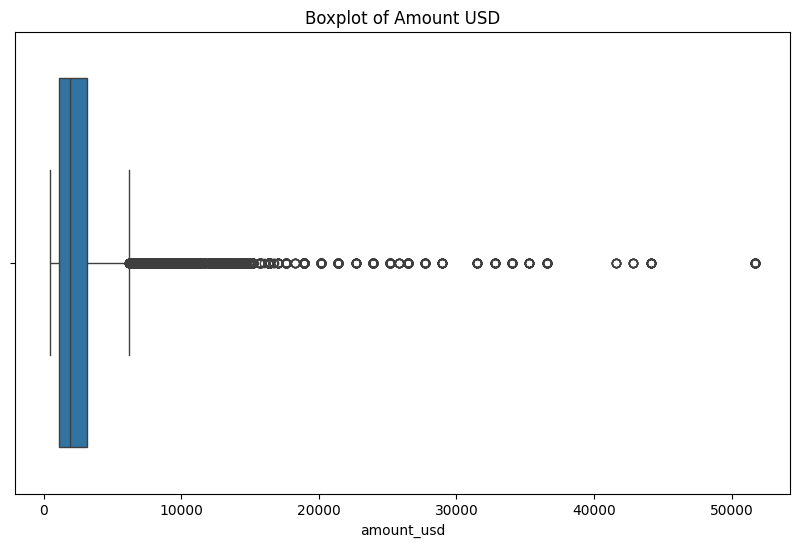

In [16]:
#Amount boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=arb_drop_df['amount'])
plt.title('Boxplot of Amount')
plt.show()

#Amount USD boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=arb_drop_df['amount_usd'])
plt.title('Boxplot of Amount USD')
plt.show()


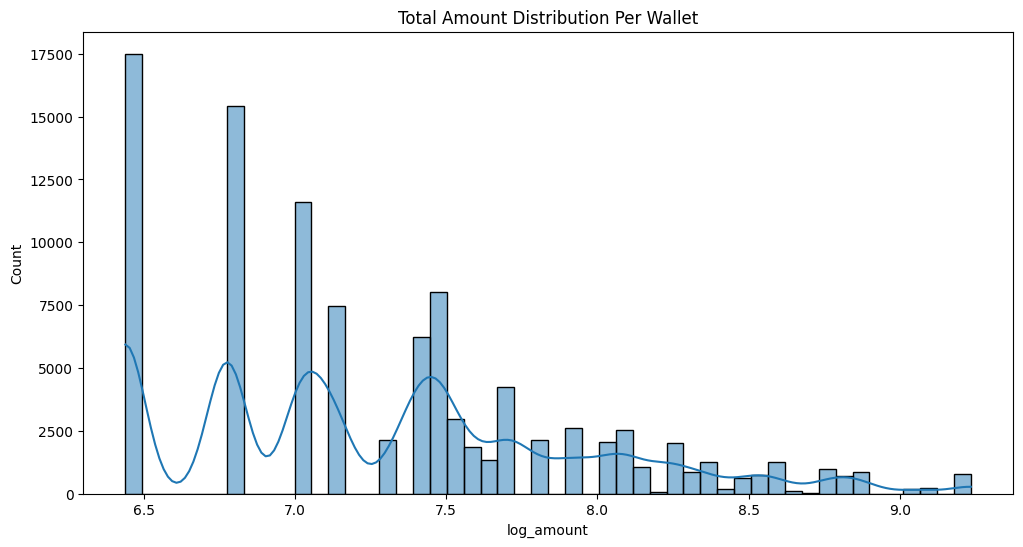

In [ ]:
wallet_summary = arb_drop_df.groupby('user_address')[['log_amount', 'log_amount_usd']].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.histplot(wallet_summary['log_amount'], bins=50, kde=True)
plt.title('Total Amount Distribution Per Wallet')
plt.show()
